Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
import os, pickle
import numpy as np
import tensorflow as tf

In [2]:
data_root = './dataset/'
pickle_file = os.path.join(data_root, 'noMNIST_sanit.pickle')

In [3]:
with open(pickle_file, 'rb') as f:
    data = pickle.load(f, encoding='bytes')
    print('Data dict\'s key:', data.keys())
    _train_dataset = data['train_dataset']
    _train_labels = data['train_labels']
    _valid_dataset = data['valid_dataset']
    _valid_labels = data['valid_labels']
    _test_dataset = data['test_dataset']
    _test_labels = data['test_labels']
    del data
    print('Train set', _train_dataset.shape, 'Labels:', _train_labels.shape)
    print('Valid set', _valid_dataset.shape, 'Labels:', _valid_labels.shape)
    print('Test set', _test_dataset.shape, 'Labels:', _test_labels.shape)

Data dict's key: dict_keys(['train_dataset', 'train_labels', 'valid_dataset', 'valid_labels', 'test_dataset', 'test_labels'])
Train set (200000, 28, 28) Labels: (200000,)
Valid set (8927, 28, 28) Labels: (8927,)
Test set (8736, 28, 28) Labels: (8736,)


In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale. 

def reformat_with_channels(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat_with_channels(_train_dataset, _train_labels)
valid_dataset, valid_labels = reformat_with_channels(_valid_dataset, _valid_labels)
test_dataset, test_labels = reformat_with_channels(_test_dataset, _test_labels)

print('Train set', train_dataset.shape, 'Labels:',train_labels.shape)
print('Valid set', valid_dataset.shape, 'Labels:',valid_labels.shape)
print('Test set', test_dataset.shape, 'Labels:',test_labels.shape)
#print('[data]:\n', test_dataset[:1], '\n', '[label]:\n', test_labels[:1])

Train set (200000, 28, 28, 1) Labels: (200000, 10)
Valid set (8927, 28, 28, 1) Labels: (8927, 10)
Test set (8736, 28, 28, 1) Labels: (8736, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer.

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    # tf_train_dataset: (16, 28, 28, 1)
    tf_train_dataset = tf.placeholder(dtype=tf.float32,
                                     shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(dtype=tf.float32,
                                    shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    
    # kernel: [5, 5, 1, 16], stride=2, padding=same
    # lay1_weights: [16, 14, 14, 16]
    lay1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    lay1_biases = tf.Variable(tf.zeros([lay1_weights.shape[-1]]))
    # conv kernel = [k_width, k_height, channel, k_num]
    # The channel size must be equal to the input's channel.
    
    # kernel: [5, 5, 16, 16], stride=2, padding=same
    # lay2_weights: [16, 7, 7, 16]
    lay2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    lay2_biases = tf.Variable(tf.zeros(depth))
    
    # Fully connect: [16, 7*7*16] * [7*7*16, num_hidden]
    # Output: [16, num_hidden]
    lay3_weights = tf.Variable(
        tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden]))
    lay3_biases = tf.Variable(tf.zeros(num_hidden))
    
    # [16, num_hidden] * [num_hidden, num_labels]
    # Output: [16, num_labels]
    lay4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    lay4_biases = tf.Variable(tf.constant(1., shape=[num_labels]))
    
    def model(data):
        # The first convolutional layer.
        conv = tf.nn.conv2d(input=data, 
                            filter=lay1_weights,
                            strides=[1,2,2,1],
                            padding='SAME')
        # Activation Function: Relu.
        hidden = tf.nn.relu(conv + lay1_biases)
        
        
        # The second convolutional layer.
        conv = tf.nn.conv2d(input=hidden,
                           filter=lay2_weights,
                           strides=[1,2,2,1],
                           padding='SAME')
        hidden = tf.nn.relu(conv + lay2_biases)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(tensor=hidden,
                            shape=[shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, lay3_weights) + lay3_biases)
        return tf.matmul(hidden, lay4_weights) + lay4_biases
    
    # Training computation
    _logits = model(tf_train_dataset)
    _loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,
                                                logits=_logits))
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(_loss)
    
    # Predictions for the training.
    train_prediction = tf.nn.softmax(_logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [7]:
steps = 100000
step_val = []
accuracy_val = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('[Tensorflow]: Initialized!')
    for step in range(steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Feed it.
        feed_dict = {tf_train_dataset: batch_data, 
                     tf_train_labels: batch_labels}
        
        _, loss, predictions = session.run([optimizer, 
                                                _loss, 
                                                train_prediction], feed_dict=feed_dict)
            
        if ((step+1) % 500 == 0):
            print('Minibatch step: %d, loss: %4.5f, acc: %.1f%%, valid_acc: %.1f%%.'
                  % ((step+1), loss,
                     accuracy(predictions, batch_labels), 
                     accuracy(valid_prediction.eval(), valid_labels)))
            step_val.append(step+1)
            accuracy_val.append(loss)
    print('Test Accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

[Tensorflow]: Initialized!
Minibatch step: 500, loss: 0.42494, acc: 87.5%, valid_acc: 74.6%.
Minibatch step: 1000, loss: 0.97117, acc: 75.0%, valid_acc: 78.6%.
Minibatch step: 1500, loss: 1.11262, acc: 75.0%, valid_acc: 78.6%.
Minibatch step: 2000, loss: 0.06846, acc: 100.0%, valid_acc: 80.7%.
Minibatch step: 2500, loss: 1.25020, acc: 75.0%, valid_acc: 80.4%.
Minibatch step: 3000, loss: 1.21836, acc: 62.5%, valid_acc: 81.3%.
Minibatch step: 3500, loss: 0.70489, acc: 81.2%, valid_acc: 81.7%.
Minibatch step: 4000, loss: 0.89826, acc: 75.0%, valid_acc: 82.2%.
Minibatch step: 4500, loss: 0.65841, acc: 75.0%, valid_acc: 81.1%.
Minibatch step: 5000, loss: 0.72821, acc: 75.0%, valid_acc: 81.0%.
Minibatch step: 5500, loss: 0.25699, acc: 87.5%, valid_acc: 83.3%.
Minibatch step: 6000, loss: 0.79658, acc: 68.8%, valid_acc: 82.9%.
Minibatch step: 6500, loss: 0.77314, acc: 81.2%, valid_acc: 82.4%.
Minibatch step: 7000, loss: 0.76092, acc: 68.8%, valid_acc: 83.1%.
Minibatch step: 7500, loss: 0.45604

Minibatch step: 61000, loss: 0.50955, acc: 75.0%, valid_acc: 85.6%.
Minibatch step: 61500, loss: 0.53470, acc: 87.5%, valid_acc: 86.4%.
Minibatch step: 62000, loss: 0.60770, acc: 81.2%, valid_acc: 85.8%.
Minibatch step: 62500, loss: 0.27533, acc: 93.8%, valid_acc: 86.2%.
Minibatch step: 63000, loss: 0.71180, acc: 81.2%, valid_acc: 85.2%.
Minibatch step: 63500, loss: 0.18595, acc: 93.8%, valid_acc: 86.2%.
Minibatch step: 64000, loss: 0.84854, acc: 75.0%, valid_acc: 86.1%.
Minibatch step: 64500, loss: 1.28051, acc: 75.0%, valid_acc: 85.7%.
Minibatch step: 65000, loss: 0.46141, acc: 81.2%, valid_acc: 85.5%.
Minibatch step: 65500, loss: 0.22123, acc: 93.8%, valid_acc: 86.5%.
Minibatch step: 66000, loss: 0.27363, acc: 87.5%, valid_acc: 85.7%.
Minibatch step: 66500, loss: 0.71987, acc: 75.0%, valid_acc: 86.2%.
Minibatch step: 67000, loss: 0.91748, acc: 68.8%, valid_acc: 86.5%.
Minibatch step: 67500, loss: 0.31753, acc: 93.8%, valid_acc: 86.0%.
Minibatch step: 68000, loss: 0.70206, acc: 93.8%

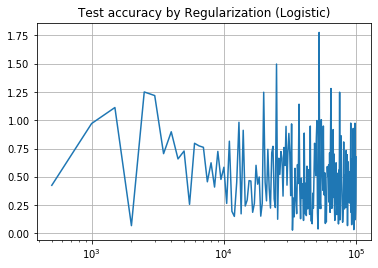

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# x轴是以对数的底的值log(x).
# plt.plot 绘制折线图.
plt.semilogx(step_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by Regularization (Logistic)')
plt.show()

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [9]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    # tf_train_dataset: (16, 28, 28, 1)
    tf_train_dataset = tf.placeholder(dtype=tf.float32,
                                     shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(dtype=tf.float32,
                                    shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    
    # kernel: [5, 5, 1, 16], stride=2, padding=same
    # lay1_weights: [16, 14, 14, 16]
    lay1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    lay1_biases = tf.Variable(tf.zeros([lay1_weights.shape[-1]]))
    # conv kernel = [k_width, k_height, channel, k_num]
    # The channel size must be equal to the input's channel.
    
    # kernel: [5, 5, 16, 16], stride=2, padding=same
    # lay2_weights: [16, 7, 7, 16]
    lay2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    lay2_biases = tf.Variable(tf.zeros(depth))
    
    # Fully connect: [16, 7*7*16] * [7*7*16, num_hidden]
    # Output: [16, num_hidden]
    lay3_weights = tf.Variable(
        tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden]))
    lay3_biases = tf.Variable(tf.zeros(num_hidden))
    
    # [16, num_hidden] * [num_hidden, num_labels]
    # Output: [16, num_labels]
    lay4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    lay4_biases = tf.Variable(tf.constant(1., shape=[num_labels]))
    
    def model(data):
        # The first convolutional layer.
        # input: [batch_size, img_height, img_width, channel]
        # output: [16, 28, 28, 16] -> convolutional kernel * 16
        conv = tf.nn.conv2d(input=data, 
                            filter=lay1_weights,
                            strides=[1,1,1,1],
                            padding='SAME')
        # Activation Function: Relu.
        hidden = tf.nn.relu(conv + lay1_biases)
        
        # stride 2 and kernel size 2.
        # input: [16, 28, 28, 16]
        # output: [16, 14, 14, 16] -> strides=2
        pool1 = tf.nn.max_pool(value=hidden, 
                               ksize=[1,2,2,1], 
                               strides=[1,2,2,1],
                               padding='SAME')
        
        
        # The second convolutional layer.
        # input: [16, 14, 14, 16], conv kernel: [5, 5], strides=2, padding=same
        # output: [16, 14, 14, 16] -> 7/2 = 3.5 -> 4
        conv = tf.nn.conv2d(input=pool1,
                           filter=lay2_weights,
                           strides=[1,1,1,1],
                           padding='SAME')
        hidden = tf.nn.relu(conv + lay2_biases)
        
        # pooling layer 2:
        # input: [16, 14, 14, 16]
        # output:  [16, 7, 7, 16]
        pool2 = tf.nn.max_pool(value=hidden, 
                               ksize=[1,2,2,1],
                               strides=[1,2,2,1],
                               padding='SAME')
        
        # shape: [16, 7, 7, 16]
        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(tensor=pool2,
                            shape=[shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, lay3_weights) + lay3_biases)
        return tf.matmul(hidden, lay4_weights) + lay4_biases
    
    # Training computation
    _logits = model(tf_train_dataset)
    _loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,
                                                logits=_logits))
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(_loss)
    
    # Predictions for the training.
    train_prediction = tf.nn.softmax(_logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [10]:
steps = 100000
step_val = []
accuracy_val = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('[Tensorflow]: Initialized!')
    for step in range(steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Feed it.
        feed_dict = {tf_train_dataset: batch_data, 
                     tf_train_labels: batch_labels}
        
        _, loss, predictions = session.run([optimizer, 
                                                _loss, 
                                                train_prediction], feed_dict=feed_dict)
            
        if ((step+1) % 500 == 0):
            print('Minibatch step: %d, loss: %4.5f, acc: %.1f%%, valid_acc: %.1f%%.'
                  % ((step+1), loss,
                     accuracy(predictions, batch_labels), 
                     accuracy(valid_prediction.eval(), valid_labels)))
            step_val.append(step+1)
            accuracy_val.append(loss)
    print('Test Accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

[Tensorflow]: Initialized!
Minibatch step: 500, loss: 0.94739, acc: 56.2%, valid_acc: 74.4%.
Minibatch step: 1000, loss: 0.91693, acc: 75.0%, valid_acc: 76.4%.
Minibatch step: 1500, loss: 0.93654, acc: 75.0%, valid_acc: 76.6%.
Minibatch step: 2000, loss: 0.05102, acc: 100.0%, valid_acc: 79.5%.
Minibatch step: 2500, loss: 1.05590, acc: 68.8%, valid_acc: 81.2%.
Minibatch step: 3000, loss: 1.38465, acc: 56.2%, valid_acc: 80.3%.
Minibatch step: 3500, loss: 0.44936, acc: 87.5%, valid_acc: 81.9%.
Minibatch step: 4000, loss: 0.89432, acc: 87.5%, valid_acc: 79.4%.
Minibatch step: 4500, loss: 0.60454, acc: 75.0%, valid_acc: 81.1%.
Minibatch step: 5000, loss: 0.42764, acc: 87.5%, valid_acc: 81.7%.
Minibatch step: 5500, loss: 0.21834, acc: 93.8%, valid_acc: 82.8%.
Minibatch step: 6000, loss: 0.62656, acc: 81.2%, valid_acc: 82.5%.
Minibatch step: 6500, loss: 0.35032, acc: 87.5%, valid_acc: 82.9%.
Minibatch step: 7000, loss: 0.76387, acc: 75.0%, valid_acc: 83.2%.
Minibatch step: 7500, loss: 0.72060

Minibatch step: 61000, loss: 0.43270, acc: 81.2%, valid_acc: 86.3%.
Minibatch step: 61500, loss: 0.30316, acc: 87.5%, valid_acc: 86.3%.
Minibatch step: 62000, loss: 0.90870, acc: 68.8%, valid_acc: 86.1%.
Minibatch step: 62500, loss: 0.35693, acc: 87.5%, valid_acc: 86.0%.
Minibatch step: 63000, loss: 0.44475, acc: 81.2%, valid_acc: 86.0%.
Minibatch step: 63500, loss: 0.27092, acc: 93.8%, valid_acc: 86.1%.
Minibatch step: 64000, loss: 0.58707, acc: 81.2%, valid_acc: 86.3%.
Minibatch step: 64500, loss: 0.95020, acc: 68.8%, valid_acc: 85.6%.
Minibatch step: 65000, loss: 0.75115, acc: 81.2%, valid_acc: 86.4%.
Minibatch step: 65500, loss: 0.22698, acc: 93.8%, valid_acc: 86.5%.
Minibatch step: 66000, loss: 0.33602, acc: 87.5%, valid_acc: 86.7%.
Minibatch step: 66500, loss: 0.77607, acc: 81.2%, valid_acc: 86.6%.
Minibatch step: 67000, loss: 0.92650, acc: 68.8%, valid_acc: 86.1%.
Minibatch step: 67500, loss: 0.33428, acc: 81.2%, valid_acc: 85.6%.
Minibatch step: 68000, loss: 0.61578, acc: 81.2%

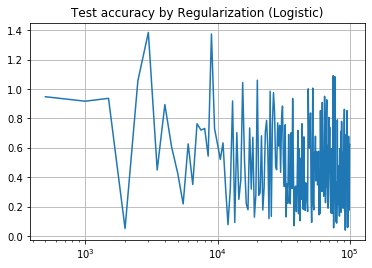

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# x轴是以对数的底的值log(x).
# plt.plot 绘制折线图.
plt.semilogx(step_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by Regularization (Logistic)')
plt.show()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

The CNN below is loosely inspired by the LeNet5 architecture.

In [14]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    # tf_train_dataset: (16, 28, 28, 1)
    tf_train_dataset = tf.placeholder(dtype=tf.float32,
                                     shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(dtype=tf.float32,
                                    shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    
    # kernel: [5, 5, 1, 16], stride=2, padding=valid
    lay1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    lay1_biases = tf.Variable(tf.zeros([lay1_weights.shape[-1]]))
    # conv kernel = [k_width, k_height, channel, k_num]
    # The channel size must be equal to the input's channel.
    
    # kernel: [5, 5, 16, 16], stride=2, padding=valid
    lay2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    lay2_biases = tf.Variable(tf.zeros(depth))
    
    # Fully connect: [7*7*16, num_hidden]
    # Output: [16, num_hidden]
    size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    lay3_weights = tf.Variable(
        tf.truncated_normal([size3 * size3 * depth, num_hidden]))
    lay3_biases = tf.Variable(tf.zeros(num_hidden))
    
    # [num_hidden, num_labels]
    lay4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    lay4_biases = tf.Variable(tf.constant(1., shape=[num_labels]))
    
    def model(data):
        # The first convolutional layer.
        # input: [batch_size, img_height, img_width, channel]
        # output: [16, 24, 24, 16] -> convolutional kernel * 16
        # C1
        conv = tf.nn.conv2d(input=data, 
                            filter=lay1_weights,
                            strides=[1,1,1,1],
                            padding='VALID')
        # Activation Function: Relu.
        hidden = tf.nn.relu(conv + lay1_biases)
        
        # stride 2 and kernel size 2.
        # input: [16, 24, 24, 16]
        # output: [16, 12, 12, 16] -> strides=2
        # S2
        pool1 = tf.nn.avg_pool(value=hidden, 
                               ksize=[1,2,2,1], 
                               strides=[1,2,2,1],
                               padding='VALID')
        
        # The second convolutional layer.
        # input: [16, 12, 12, 16], conv kernel: [5, 5], strides=2, padding=same
        # output: [16, 8, 8, 16]
        # C3
        conv = tf.nn.conv2d(input=pool1,
                           filter=lay2_weights,
                           strides=[1,1,1,1],
                           padding='VALID')
        hidden = tf.nn.relu(conv + lay2_biases)
        
        # pooling layer 2:
        # input: [16, 8, 8, 16]
        # output:  [16, 4, 4, 16]
        # S4
        pool2 = tf.nn.max_pool(value=hidden, 
                               ksize=[1,2,2,1],
                               strides=[1,2,2,1],
                               padding='VALID')
        
        # shape: [16, 4, 4, 16]
        # F5
        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(tensor=pool2,
                            shape=[shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, lay3_weights) + lay3_biases)
        return tf.matmul(hidden, lay4_weights) + lay4_biases
    
    # Training computation
    _logits = model(tf_train_dataset)
    _loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,
                                                logits=_logits))
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(_loss)
    
    # Predictions for the training.
    train_prediction = tf.nn.softmax(_logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [15]:
steps = 100000
step_val = []
accuracy_val = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('[Tensorflow]: Initialized!')
    for step in range(steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Feed it.
        feed_dict = {tf_train_dataset: batch_data, 
                     tf_train_labels: batch_labels}
        
        _, loss, predictions = session.run([optimizer, 
                                                _loss, 
                                                train_prediction], feed_dict=feed_dict)
            
        if ((step+1) % 500 == 0):
            print('Minibatch step: %d, loss: %4.5f, acc: %.1f%%, valid_acc: %.1f%%.'
                  % ((step+1), loss,
                     accuracy(predictions, batch_labels), 
                     accuracy(valid_prediction.eval(), valid_labels)))
            step_val.append(step+1)
            accuracy_val.append(loss)
    print('Test Accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

[Tensorflow]: Initialized!
Minibatch step: 500, loss: 0.63997, acc: 75.0%, valid_acc: 77.1%.
Minibatch step: 1000, loss: 0.98649, acc: 75.0%, valid_acc: 80.4%.
Minibatch step: 1500, loss: 0.71715, acc: 75.0%, valid_acc: 81.2%.
Minibatch step: 2000, loss: 0.10359, acc: 100.0%, valid_acc: 81.4%.
Minibatch step: 2500, loss: 0.80015, acc: 75.0%, valid_acc: 81.0%.
Minibatch step: 3000, loss: 1.49320, acc: 62.5%, valid_acc: 81.8%.
Minibatch step: 3500, loss: 0.50431, acc: 75.0%, valid_acc: 82.2%.
Minibatch step: 4000, loss: 0.98100, acc: 75.0%, valid_acc: 83.7%.
Minibatch step: 4500, loss: 0.63293, acc: 81.2%, valid_acc: 82.8%.
Minibatch step: 5000, loss: 0.89297, acc: 75.0%, valid_acc: 83.4%.
Minibatch step: 5500, loss: 0.43056, acc: 87.5%, valid_acc: 82.7%.
Minibatch step: 6000, loss: 0.94969, acc: 62.5%, valid_acc: 84.4%.
Minibatch step: 6500, loss: 0.73003, acc: 75.0%, valid_acc: 83.3%.
Minibatch step: 7000, loss: 0.53805, acc: 81.2%, valid_acc: 83.8%.
Minibatch step: 7500, loss: 0.56240

Minibatch step: 61000, loss: 0.51547, acc: 87.5%, valid_acc: 86.8%.
Minibatch step: 61500, loss: 0.41444, acc: 87.5%, valid_acc: 87.2%.
Minibatch step: 62000, loss: 0.56213, acc: 75.0%, valid_acc: 87.1%.
Minibatch step: 62500, loss: 0.19443, acc: 93.8%, valid_acc: 87.0%.
Minibatch step: 63000, loss: 0.65047, acc: 75.0%, valid_acc: 87.2%.
Minibatch step: 63500, loss: 0.23113, acc: 87.5%, valid_acc: 87.4%.
Minibatch step: 64000, loss: 0.63255, acc: 81.2%, valid_acc: 87.2%.
Minibatch step: 64500, loss: 1.08483, acc: 75.0%, valid_acc: 86.9%.
Minibatch step: 65000, loss: 0.35190, acc: 87.5%, valid_acc: 87.6%.
Minibatch step: 65500, loss: 0.28512, acc: 87.5%, valid_acc: 87.5%.
Minibatch step: 66000, loss: 0.25661, acc: 93.8%, valid_acc: 87.3%.
Minibatch step: 66500, loss: 0.44769, acc: 87.5%, valid_acc: 87.5%.
Minibatch step: 67000, loss: 0.83054, acc: 87.5%, valid_acc: 87.3%.
Minibatch step: 67500, loss: 0.52935, acc: 87.5%, valid_acc: 87.6%.
Minibatch step: 68000, loss: 0.36702, acc: 93.8%

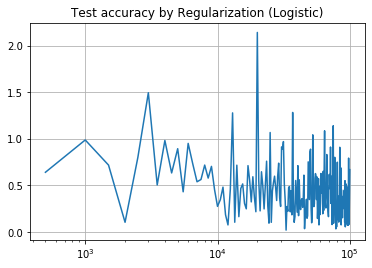

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# x轴是以对数的底的值log(x).
# plt.plot 绘制折线图.
plt.semilogx(step_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by Regularization (Logistic)')
plt.show()